# Q-learning with Tensorflow

Our agent needs to cross a lake, represented by a square divided with a 4x4 grid. At every step he needs to take an action, he can go up, down, left or right. If it's not possible to go to the chosen direction our agent will simply not move.

Each grid element can be frozen, in that case our agent will be able to move, it can he a hole, in that case the episodes end and we don't get the reward or it can be the final state, the goal. In that case the agent will receive a positive reward.

We want to use q-learning and tensorflow to solve this problem.

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,8)

%matplotlib inline

In [2]:
env = gym.make('FrozenLake-v0')

In [3]:

n_actions = env.action_space.n
n_states = env.observation_space.n

# Actions are left, up, right, down
print(f'Number of actions {n_actions}')
# States are the 16 fields
print(f'Number of possible states {n_states}')

Number of actions 4
Number of possible states 16


The enviroment looks at the start:

In [4]:
env.render()


SFFF
FHFH
FFFH
HFFG


In [5]:
env.reset()
env.step(1)
env.step(2)

(0, 0.0, False, {'prob': 0.3333333333333333})

In [6]:
env.render()

  (Right)
SFFF
FHFH
FFFH
HFFG


## Solving using a Q-Network 

### Network implementation

In [7]:
# Clears the default graph stack and resets the global default graph.
# Useful during the testing phase while I experiment in jupyter notebook.
tf.reset_default_graph()

In [8]:
#  Creating a placeholder for the inputs
inputs = tf.placeholder(shape=[1,n_states],dtype=tf.float32)

In [9]:
# Creating the initial weights as a small randomized matrix
# In this simple example we will use only one set of weights
mean = 0
std = 0.01
init_weights = tf.random_uniform([n_states, n_actions], mean, std)


In [10]:
# Visualizing the initial weights
with tf.Session() as sess_test:
    print(init_weights.eval())

[[0.00342309 0.00976495 0.00214293 0.00723454]
 [0.00537453 0.00656457 0.0040199  0.00543229]
 [0.00511364 0.00435218 0.00365521 0.00984944]
 [0.00114101 0.00346849 0.00376868 0.00916669]
 [0.0053108  0.00515314 0.00690253 0.00936098]
 [0.00894566 0.0010474  0.00331864 0.00586872]
 [0.00340443 0.00888585 0.00398917 0.00876538]
 [0.00716173 0.00175659 0.0071603  0.00412093]
 [0.00410259 0.00580661 0.00996704 0.00457001]
 [0.00701685 0.00089319 0.00465623 0.00509462]
 [0.00097011 0.00451427 0.00929863 0.00703922]
 [0.00449263 0.00033897 0.00665131 0.00712478]
 [0.00544938 0.00515706 0.00838579 0.00272612]
 [0.00617148 0.0087359  0.00326728 0.00721616]
 [0.0080994  0.00536759 0.00148304 0.00640288]
 [0.00706806 0.008718   0.00173838 0.00339564]]


In [18]:
# create the variable to hold the weights
weights = tf.Variable(init_weights)

# Matrix product betwen inputs and weights
q_out = tf.matmul(inputs, weights)

# The prediction is the action that gives the maximum reward maximum 
predict = tf.argmax(q_out, axis=1)

In [ ]:
tf.global_variables_initializer()
sess = tf.Session()
sess.run()
tf.Variable()
tf.placeholder(shape=[1, n_actions],dtype=tf.float32)
tf.matmul(matrix1, matrix2)
tf.argmax(matrix, axis=)
tf.reduce_sum()
tf.train.GradientDescentOptimizer()
trainer.minimize(loss)

In [14]:
# We calculate the loss
# by taking the sum of squares difference between the target and predicted Q values.
next_q = tf.placeholder(shape=[1, n_actions],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(next_q - q_out))
# We use a simple gradient descent
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
update_model = trainer.minimize(loss)

### Training the network

In [18]:
init = tf.global_variables_initializer()

# Set learning parameters
y = .99
epsilon = 0.3
num_episodes = 1000
epsilon_decay = 0.999
max_steps = 20

# To keep track of the trainig hisotry
step_list = []
reward_list = []
success = 0

def epsilon_greedy(predict, q_out, s, epsilon):
    a, q_matrix = sess.run([predict, q_out],
                           feed_dict={inputs: np.identity(n_states)[s:s + 1]})
    if np.random.rand(1) < epsilon:
        a[0] = env.action_space.sample()
    return a, q_matrix


with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        total_reward = 0
        done = False

        for step in range(max_steps):
            # Choose an action using epsilon greedy using the Q-network
            a, q_matrix = epsilon_greedy(predict, q_out, s, epsilon)
            # Receive new state and reward from environment
            s_prime, reward, done, _ = env.step(a[0])
            # Calculate Q' using the network
            q_prime = sess.run(
                q_out,
                feed_dict={inputs: np.identity(n_states)[s_prime:s_prime + 1]})
            # Obtain max_q_prime and set our target value for chosen action.
            max_q_prime = np.max(q_prime)
            target_q = q_matrix
            target_q[0, a[0]] = reward + y * max_q_prime
            # Train our network using target and predicted Q values
            _, w_prime = sess.run([update_model, weights],
                                  feed_dict={
                                      inputs: np.identity(n_states)[s:s + 1],
                                      next_q: target_q
                                  })
            total_reward = total_reward + reward
            s = s_prime
            # As we train the model reduces epsilon to reduce the random actions
            epsilon = epsilon * epsilon_decay
            if done == True:
                break

        step_list.append(step)
        reward_list.append(total_reward)

print("Percent of succesful episodes: " + str((sum(reward_list) * 100) / num_episodes) +
      "%")

Percent of succesful episodes: 6.0%


### Some statistics on network performance

We can see that the network beings to consistly reach the goal around the 300 episode mark.

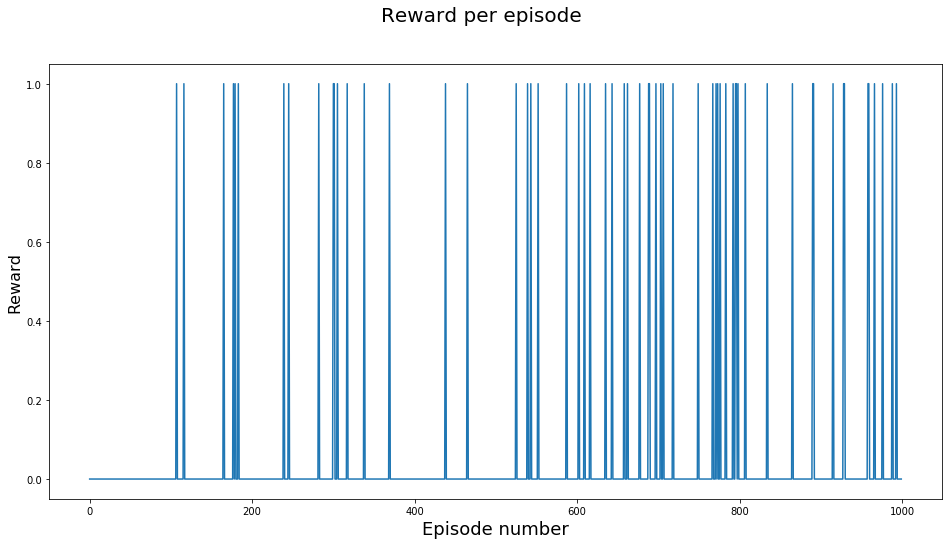

In [24]:
fig = plt.figure()
plt.plot(reward_list)
fig.suptitle('Reward per episode', fontsize=20)
plt.xlabel('Episode number', fontsize=18)
plt.ylabel('Reward', fontsize=16)

plt.show()

It also begins to progress through the environment for longer than chance aroudn the 750 mark as well.

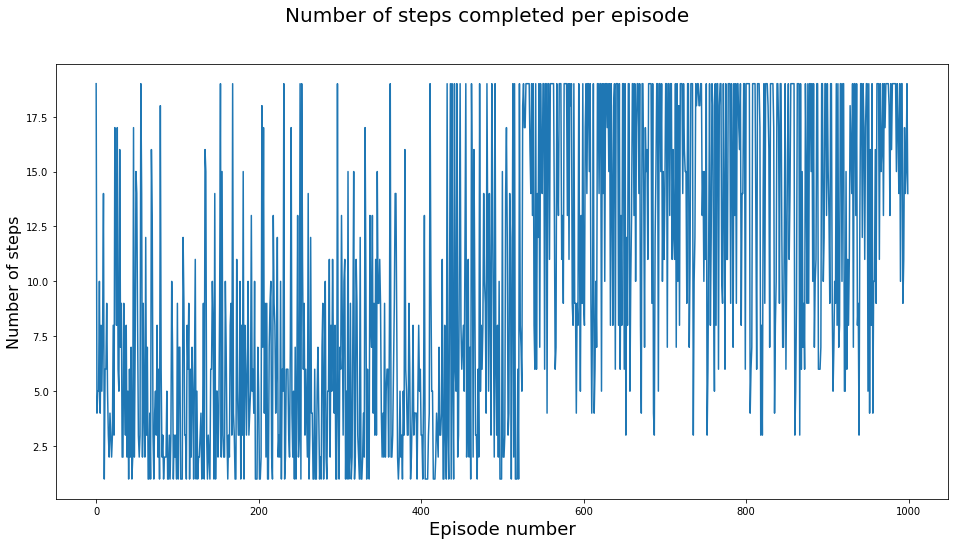

In [25]:
fig = plt.figure()
plt.plot(step_list)
fig.suptitle('Number of steps completed per episode', fontsize=20)
plt.xlabel('Episode number', fontsize=18)
plt.ylabel('Number of steps', fontsize=16)